**Import Tensorflow as Neural Network package**

In [9]:
import pandas as pd 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 

In [10]:
Data = pd.read_csv("../../../4 - Data/04_WorkingDatasets/Top50Combined/50MostImp+CombinedFeatures.csv")
Target = pd.read_csv("../../../4 - Data/04_WorkingDatasets/Top50CombLagged/TargetOutliersTreated.csv")

In [11]:
Target.head()

Data = Data[Data['Datum'] >= '2022-01-02 01:00:00+00:00']
Data.drop(columns = ['Datum'], inplace = True)
Data.head()


,pm10_stundenmittelwerte_ug_m3,pm2_5_stundenmittelwerte_ug_m3,PM10 [ug/m3],PM2.5 [ug/m3],NO2 [ug/m3],NOX [ug/m3 eq. NO2],no2_stundenmittelwerte_ug_m3,CPC [1/cm3],Basel Wind Direction [10 m],Basel Wind Speed [10 m],...,Basel Wind Speed [10 m]_x_Basel Wind Speed [10 m],Basel Wind Speed [10 m]_x_Basel Wind Direction [10 m],Basel Wind Speed [10 m]_x_Gasverbrauch,Basel Wind Speed [10 m]_x_Hour,Basel Wind Direction [10 m]_x_Basel Wind Direction [10 m],Basel Wind Direction [10 m]_x_Hour,406v_sumLW_x_408n_sumLief,660n_sumPW_x_Gasverbrauch,Gasverbrauch_x_Gasverbrauch,Gasverbrauch_x_Hour
25,0.369263,0.761473,0.581652,1.061620,1.256610,1.098958,-0.244049,0.507241,-0.072796,-0.273750,...,-0.419390,-0.174460,-0.285458,-0.066308,-0.899194,-0.024385,0.180482,-0.797138,-0.524208,0.076509
26,0.275948,0.699860,0.309943,0.819359,1.084468,0.836139,-0.300256,0.214210,-0.072796,-0.273750,...,-0.419390,-0.174460,-0.311684,-0.085808,-0.899194,-0.028700,-0.007376,-0.836521,-0.462041,0.126981
27,0.140982,0.567541,0.242016,0.748105,0.984806,0.773562,-0.321188,0.088324,-0.182397,-0.091965,...,-0.446583,-0.177671,-0.222522,-0.064003,-0.876278,-0.056258,0.258004,-0.803148,-0.190749,0.237890
28,-0.001124,0.466301,0.185410,0.719604,0.930446,0.992579,-0.364334,0.444500,-0.243905,0.085512,...,-0.444501,-0.219537,0.004998,-0.015965,-0.853920,-0.085714,0.156083,-0.419025,0.571741,0.464562
29,-0.061715,0.393152,0.151447,0.691103,0.821724,1.092701,-0.289761,0.314072,-0.325010,0.157978,...,-0.435517,-0.255000,0.196703,0.019188,-0.814000,-0.130792,-0.007376,-0.418860,1.440262,0.731748


In [12]:
# Beispiel: Annahme, X.shape[0] = 1000 (1000 Zeitpunkte)
n = Data.shape[0]
X = Data.copy()
y = Target["PM10_Combined_Trend_Residual"].copy()

# Split-Größen definieren
train_size = int(n * 0.7)  # 70% Training
val_size = int(n * 0.2)    # 20% Validierung
test_size = n - train_size - val_size  # 10% Test

# Training (älteste Daten)
X_train, y_train = X[:train_size], y[:train_size]

# Validierung (neuere Daten)
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]

# Test (neueste Daten)
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


In [13]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [15]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])


Epoch 1/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 41.5746 - mae: 4.2883 - mse: 38.9477 - val_loss: 32.5690 - val_mae: 3.5008 - val_mse: 30.2757
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.4705 - mae: 3.1133 - mse: 18.2868 - val_loss: 32.8582 - val_mae: 3.5567 - val_mse: 30.9400
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.8573 - mae: 2.9828 - mse: 17.0235 - val_loss: 32.0580 - val_mae: 3.5293 - val_mse: 30.4329
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.6362 - mae: 2.9546 - mse: 17.0689 - val_loss: 32.3215 - val_mae: 3.5831 - val_mse: 30.8993
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.5643 - mae: 2.8367 - mse: 15.1886 - val_loss: 30.4618 - val_mae: 3.4832 - val_mse: 29.1951
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17.0355 - mae: 2.8738 - mse: 15.7977 - val_loss: 30.3442 - val_mae: 3.5068 - val_mse: 29.1662
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - l

In [17]:
print(X_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in X_test
print(y_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in y_test


(2456, 66)
(2456,)


In [18]:
results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8355 - mae: 2.3031 - mse: 8.8127
Test loss, Test MAE: [10.819661140441895, 2.4832632541656494, 9.796903610229492]


In [19]:
model2 = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE, Test MSE:", results)

Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 51.2207 - mae: 4.8422 - mse: 48.5334 - val_loss: 34.2143 - val_mae: 3.5895 - val_mse: 31.8394
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 22.3968 - mae: 3.3008 - mse: 20.1326 - val_loss: 32.7765 - val_mae: 3.5985 - val_mse: 30.7993
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 22.1127 - mae: 3.2756 - mse: 20.2181 - val_loss: 32.2433 - val_mae: 3.5176 - val_mse: 30.5674
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21.6038 - mae: 3.2249 - mse: 19.9754 - val_loss: 32.6837 - val_mae: 3.6152 - val_mse: 31.2192
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 19.9758 - mae: 3.1458 - mse: 18.5573 - val_loss: 31.6882 - val_mae: 3.5297 - val_mse: 30.3727
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.9460 - mae: 3.1904 - mse: 19.6513 - val_loss: 30.9752 - val_mae: 3.4877 - val_mse: 29.7514
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.3268

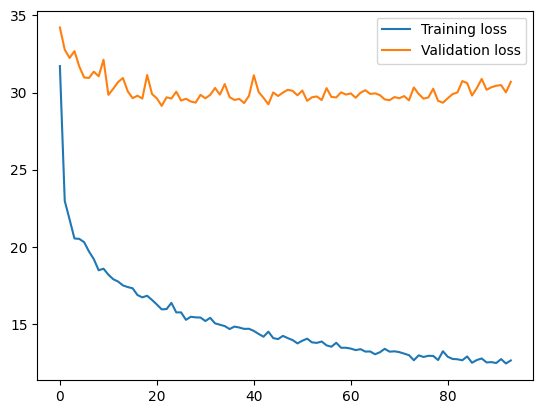

In [20]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [21]:
model3 = Sequential([
    Dense(512, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.15),
    Dense(256, activation='relu'),
    Dropout(0.38),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='relu'),
])

optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=15, min_lr=1e-6)



history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)



Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 36.3528 - mae: 3.9837 - mse: 33.5039 - val_loss: 33.4771 - val_mae: 3.5996 - val_mse: 31.0949
Epoch 2/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 19.8795 - mae: 3.0573 - mse: 17.6524 - val_loss: 31.9951 - val_mae: 3.5529 - val_mse: 30.1573
Epoch 3/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 19.8612 - mae: 3.0068 - mse: 18.1251 - val_loss: 31.5869 - val_mae: 3.5222 - val_mse: 30.0752
Epoch 4/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.7699 - mae: 2.8794 - mse: 15.3205 - val_loss: 32.7803 - val_mae: 3.7018 - val_mse: 31.4456
Epoch 5/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17.0332 - mae: 2.8886 - mse: 15.7284 - val_loss: 30.7625 - val_mae: 3.4928 - val_mse: 29.5483
Epoch 6/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 15.9981 - mae: 2.8102 - mse: 14.8109 - val_loss: 31.6328 - val_mae: 3.5424 - val_mse: 30.4818
Epoch 7/800
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.0353

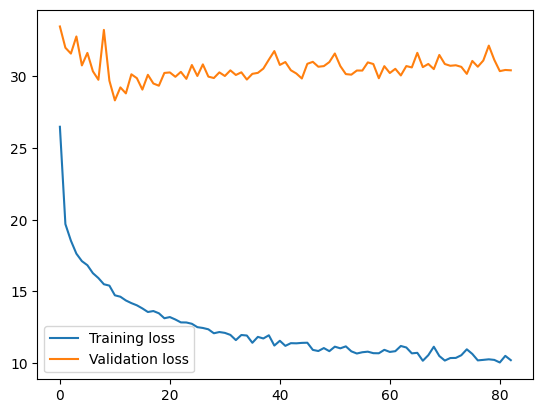

In [22]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


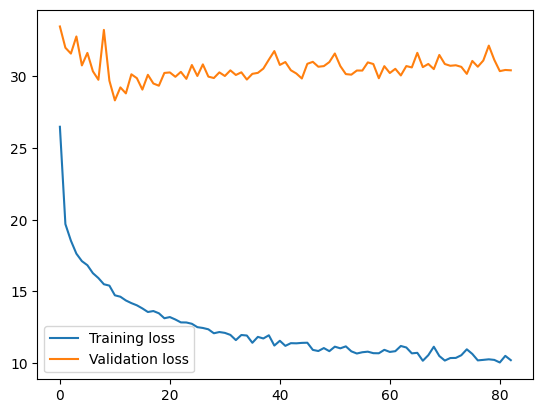

In [23]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [24]:
# Berechnen des Total MSE

from sklearn.metrics import mean_squared_error

# Vorhersagen für den gesamten Datensatz
y_pred = model.predict(X)

# MSE berechnen
total_mse = mean_squared_error(y, y_pred)
print(f"Gesamter MSE: {total_mse}")



y_pred = model2.predict(X)

# MSE berechnen
total_mse = mean_squared_error(y, y_pred)
print(f"Gesamter MSE: {total_mse}")


y_pred = model3.predict(X)

# MSE berechnen
total_mse = mean_squared_error(y, y_pred)
print(f"Gesamter MSE: {total_mse}")

768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
Gesamter MSE: 14.921140027146018
768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step
Gesamter MSE: 15.142548341437896
768/768 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step
Gesamter MSE: 14.849966324164741
